# 8. Gyakorlat: Generatív modellek - Naive Bayes

In [10]:
import re
import nltk
import warnings
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings('ignore')

## Adatok feldolgozása
> A spam.csv e-mail szövegeket tartalmaz, hozzájuk tartozóan pedig a bináris osztályt, mely szerint spam (kéretlen) vagy ham (kért) üzenetről van-e szó.

A modellezés célja olyan természetes nyelv felismerőt felállítani, amely képes eldönteni, kéretlen e-mail-t kaptunk-e.

In [11]:
df = pd.read_csv('spam.csv', encoding='latin')
print(df.shape)
df.drop([x for x in df.columns if 'Unnamed' in x], axis=1, inplace=True)
df.columns = ['class', 'text']
df.head()

(5572, 5)


,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Vizualizáció, átalakítás

In [12]:
df.groupby('class').count()['text']

class
ham     4825
spam     747
Name: text, dtype: int64

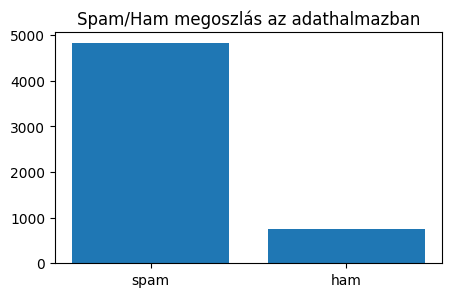

In [13]:
plt.figure(figsize=(5, 3))
plt.title('Spam/Ham megoszlás az adathalmazban')
plt.bar(['spam', 'ham'], df.groupby('class').count()['text'])
plt.show()

### Töltsük le az angol nyelvben taláható felesleges szavakat, mint az "is", "at"
A stopszavak olyan szavak, amelyek nem hordoznak olyan jelentést, ami egyedi lenne az adott osztályra.

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KuknyDa00\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Előfeldolgozás

In [15]:
stemmer = PorterStemmer() # Ugyanazon szavak más alakú előfordulását lecsökkenti, pl. "argue", "arguing", "argued" 
words = stopwords.words("english")

df['processedtext'] = df['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

print(df.shape)
print(df.head(10))

(5572, 3)
  class                                               text  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   
5  spam  FreeMsg Hey there darling it's been 3 week's n...   
6   ham  Even my brother is not like to speak with me. ...   
7   ham  As per your request 'Melle Melle (Oru Minnamin...   
8  spam  WINNER!! As a valued network customer you have...   
9  spam  Had your mobile 11 months or more? U R entitle...   

                                       processedtext  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri wkli comp win fa cup final tkt st m...  
3                u dun say earli hor u c alreadi say  
4             nah i think goe us

### Train-test szétválasztás

In [16]:
target = df['class']

X_train, X_test, y_train, y_test = train_test_split(df['processedtext'], target, test_size=0.30, random_state=100)

print(df.shape); print(X_train.shape); print(X_test.shape)

(5572, 3)
(3900,)
(1672,)


### Szavak vektorizálása: a szavak előfordulását gyakorisági vektorokká alakítja

In [17]:
# TF: Term-frequency: normalizált gyakoriság az egész dokumentumban
# IDF: Inverse Document Frequency: Csökkenti azoknak a szavaknak a súlyát, amik dokumentum-szerte mindenhol előfordulnak
vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)

train_tfIdf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))

test_tfIdf = vectorizer_tfidf.transform(X_test.values.astype('U'))

print(vectorizer_tfidf.get_feature_names_out()[:10])

print("Train dimenziók:", train_tfIdf.shape)
print("Test dimenziók:", test_tfIdf.shape)

['aah' 'aaniy' 'aaooooright' 'aathi' 'abbey' 'abeg' 'abel' 'aberdeen'
 'abi' 'abil']
Train dimenziók: (3900, 5139)
Test dimenziók: (1672, 5139)


## Osztályozó létrehozása, tanítás és predikció

In [18]:
nb_classifier = MultinomialNB()

nb_classifier.fit(train_tfIdf, y_train)

pred2 = nb_classifier.predict(test_tfIdf) 
print(pred2[:10])

['ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham']


### Metrika 

In [19]:
accuracy_tfidf = metrics.accuracy_score(y_test, pred2)
print(f'Pontosság: {round(accuracy_tfidf * 100, 2)}%')

Conf_metrics_tfidf = metrics.confusion_matrix(y_test, pred2, labels=['ham', 'spam'])

Pontosság: 96.83%


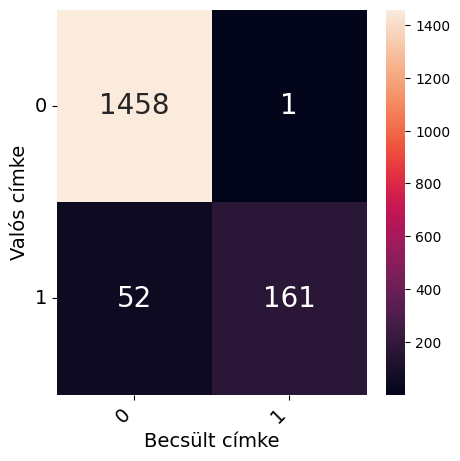

In [20]:
def plot_conf_mtx(metrics_mtx):
    plt.figure(figsize=(5,5))
    confusion_matrix_df = metrics_mtx

    heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d") # Korrelációs mátrix 
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14) 
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize = 14)

    plt.ylabel('Valós címke', fontsize = 14)
    plt.xlabel('Becsült címke', fontsize = 14)
    plt.show()

plot_conf_mtx(Conf_metrics_tfidf)

---
# Próbáljuk ki ugyanezt az eljárást egy véletlen erdővel!
> A véletlen erdő egy együttes tanulási eljárás, amely tanítás közben hoz létre döntési fákat. Előnye, hogy kevés konfigurációval mélyebb belátást biztosít az adatokban rejlő kapcsolatokra.

In [21]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 100)

classifier.fit(train_tfIdf, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=100)

## RF osztályozó kiértékelése
Melyik teljesített jobban?

['ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham']
Accuracy: 0.9754784688995215


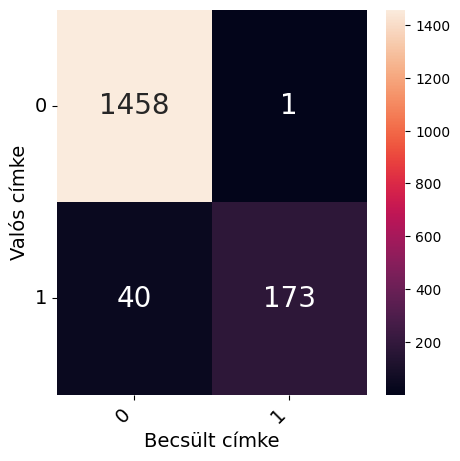

In [22]:
predRF = classifier.predict(test_tfIdf) 
print(predRF[:10])

# Számoljuk ki a pontosságot
accuracy_RF = metrics.accuracy_score(y_test, predRF)
print("Accuracy:", accuracy_RF)

Conf_metrics_RF = metrics.confusion_matrix(y_test, predRF, labels=['ham', 'spam'])
plot_conf_mtx(Conf_metrics_RF)